# Introduction to Q-Learning

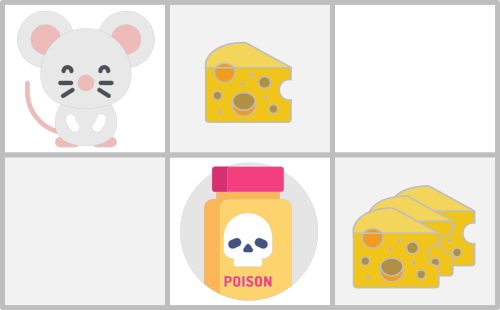

Inspiration: https://huggingface.co/learn/deep-rl-course/en/unit2/q-learning-example

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from typing import List, Tuple

/tmp/ipykernel_33402/354846443.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Set up the problem

In [2]:
# Define environment parameters
n_rows = 4
n_cols = 4
n_actions = 4  # Up, Down, Left, Right

# Define the initial Q-table with zeros
q_table = np.zeros((n_rows * n_cols, n_actions))

In [3]:
# Define the rewards and game over conditions
rewards = np.zeros((n_rows, n_cols))
rewards[3, 3] = 100  # Goal: (Big piece of cheese)
rewards[2, 1] = 30 # Small Reward
rewards[1, 1] = -100 # Poison
rewards[1, 3] = -100 # Poison
rewards[2, 3] = -100 # Poison
rewards[3, 0] = -100 # Poison

game_over_positions = [
    (1, 1), # Poison
    (1, 3), # Poison
    (2, 3), # Poison
    (3, 0), # Poison
    (3, 3), # Goal
    ]

### Apply Training

In [4]:
def get_valid_actions(position:Tuple[int, int], n_rows:int, n_cols:int) -> Tuple[List[int], List[int]]:
    """Returns a list of valid actions given a position and the grid dimensions."""
    valid_actions = []
    invalid_actions = []
    if position[0] > 0:  # Up
        valid_actions.append(0)
    else:
        invalid_actions.append(0)
    if position[0] < n_rows - 1:  # Down
        valid_actions.append(1)
    else:
        invalid_actions.append(1)
    if position[1] > 0:  # Left
        valid_actions.append(2)
    else:
        invalid_actions.append(2)
    if position[1] < n_cols - 1:  # Right
        valid_actions.append(3)
    else:
        invalid_actions.append(3)
    return valid_actions, invalid_actions

In [5]:
def choose_action(state:Tuple[int, int], q_table:np.array, valid_actions:int, exploration_rate:int) -> int:
    """Choose an action based on epsilon-greedy strategy."""
    if np.random.uniform(0, 1) < exploration_rate:
        action = np.random.choice(valid_actions)
    else:
        state_index = state[0] * n_cols + state[1]  # Index from flattened state
        q_values = q_table[state_index, valid_actions]
        max_q_value = np.max(q_values)
        # Get all indices with maximum Q-value
        max_indices = np.where(q_values == max_q_value)[0]
        # Randomly choose one from the maximum indices
        action = np.random.choice(max_indices)
    return action

In [6]:
def update_state(state:tuple, action:int, n_rows:int, n_cols:int) -> Tuple[int, int]:
    """Update the current state based on the chosen action."""
    if action == 0:  # Up
        next_state = (max(0, state[0] - 1), state[1])
    elif action == 1:  # Down
        next_state = (min(n_rows - 1, state[0] + 1), state[1])
    elif action == 2:  # Left
        next_state = (state[0], max(0, state[1] - 1))
    else:  # Right
        next_state = (state[0], min(n_cols - 1, state[1] + 1))
    return next_state

In [7]:
def get_reward(state:Tuple[int, int], reward_state:np.array, penalty:int=0) -> Tuple[int, np.array]:
    """
    Calculate the reward based on the given transition.
    """
    # Create a copy of the reward state to avoid modifying the original
    updated_reward_state = deepcopy(reward_state)
    base_reward = reward_state[state[0], state[1]]
    if base_reward > 0:
        updated_reward_state[state[0], state[1]] = 0
    reward = base_reward + penalty
    return reward, updated_reward_state

def update_q_table(q_table:np.array, state:Tuple[int, int], action:int, invalid_actions:List[int], next_state:int, reward:int, step_penalty:int, learning_rate:int, discount_factor:int, n_cols:int) -> np.array:
    """Update the Q-table using the Bellman equation."""
    state_index = state[0] * n_cols + state[1]
    next_state_index = next_state[0] * n_cols + next_state[1]
    max_next_q_value = np.max(q_table[next_state_index])
    q_table[state_index, invalid_actions] = -np.inf  # Mark invalid actions with -inf

    # Update the Q-value of the current state and action
    q_table[state_index, action] = (1 - learning_rate) * q_table[state_index, action] + \
                                           learning_rate * (reward + step_penalty + discount_factor * max_next_q_value)
    return q_table

In [8]:
def update_q_table_end_game(q_table:np.array, state:tuple, reward_state:np.array, n_cols:int) -> np.array:
    """Update the Q-Table based on the instadeath reward/punishment"""        
    reward, _ = get_reward(state, reward_state, penalty=0)
    q_table = update_q_table_instant_end(q_table, state, reward, n_cols)
    return q_table

def update_q_table_instant_end(q_table, state, reward, n_cols) -> np.array:
    state_index = state[0] * n_cols + state[1]
    q_table[state_index, :] = reward
    return q_table


In [9]:
# Q-learning parameters
learning_rate = 0.8
discount_factor = 0.9
exploration_rate = 0.9
exploration_decay = 0.85
n_episodes = 10_000
max_steps = 15
print_statements = False

# Spell out Action names
action_names = ['Up', 'Down', 'Left', 'Right']

In [10]:
# Q-learning algorithm
for episode in range(n_episodes):
    # Reset the environment to the starting position
    current_state = (0, 0)
    current_exploration_rate = deepcopy(exploration_rate)
    reward_state = deepcopy(rewards)
    step_penalty = 0

    if current_state in game_over_positions:
        q_table = update_q_table_end_game(q_table, current_state, reward_state, n_cols)
        continue

    for step in range(max_steps):
        # Get step penalty to optimize number of actions
        step_penalty -= 2

        # Get the list of valid actions for the current state
        valid_actions, invalid_actions = get_valid_actions(current_state, n_rows, n_cols)
        
        # Choose an action based on epsilon-greedy strategy
        action = choose_action(current_state, q_table, valid_actions, exploration_rate)

        # Update the current state based on the chosen action
        next_state = update_state(current_state, action, n_rows, n_cols)

        # Get the reward for the new state
        reward, reward_state = get_reward(next_state, reward_state)

        # Update the Q-table using the Bellman equation
        q_table = update_q_table(q_table, current_state, action, invalid_actions, next_state, reward, step_penalty, learning_rate, discount_factor, n_cols)

        # Print the current state of the environment
        if print_statements:
            print(f"Episode: {episode + 1}")
            print(f"Exploration rate: {current_exploration_rate:.2f}")
            print(f"Current state: {current_state}")
            print(f"The valid actions are {valid_actions}") 
            print(f"The available actions are: {list(map(lambda action: action_names[action], valid_actions))}.")
            print(f"The chosen action is {action}")
            print(f"The direction is {action_names[action]}.")
            print(f"The next state is {next_state}.")
            print(f"The reward for the new state is {reward}.")
            print(f"The updated Q-table is:\n{q_table}\n")

        # Move to the next state
        current_state = next_state

        # Update the exploration rate
        current_exploration_rate *= exploration_decay

        # Check if the episode is finished
        if current_state in game_over_positions:
            q_table = update_q_table_end_game(q_table, current_state, reward_state, n_cols)
            break

In [11]:
# Print the learned Q-table
print("Learned Q-table:")
q_table_df = pd.DataFrame(q_table, columns=action_names).round(2)
q_table_df

Learned Q-table:


,Up,Down,Left,Right
0,-inf,34.60,-inf,12.37
1,-inf,-196.31,16.21,5.08
2,-inf,13.73,9.52,-6.36
3,-inf,-201.27,3.18,-inf
4,24.96,41.58,-inf,-203.59
5,-100.00,-100.00,-100.00,-100.00
6,15.17,22.75,-198.85,-201.35
7,-100.00,-100.00,-100.00,-100.00
8,27.55,-197.74,-inf,50.86
9,-206.67,35.47,38.83,30.41


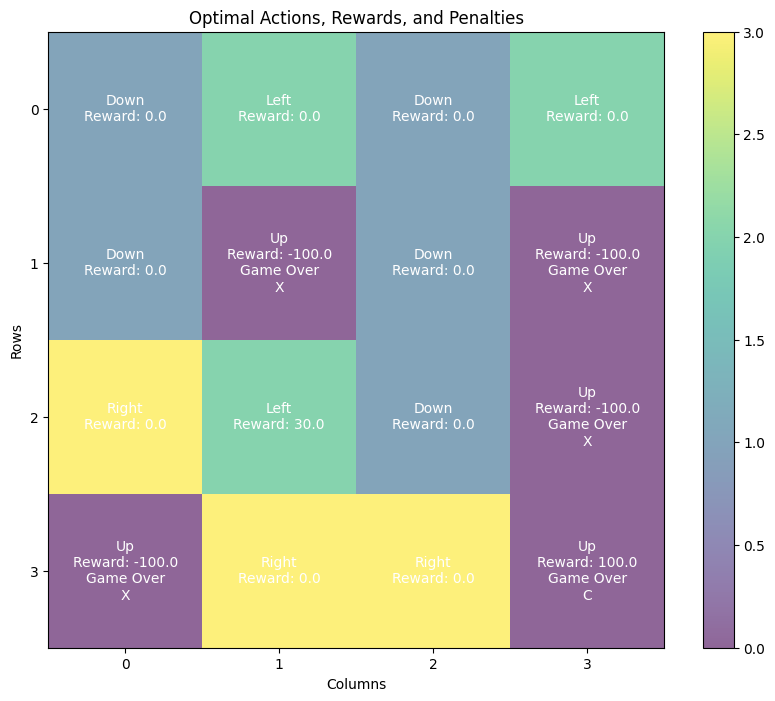

In [12]:
# Function to get optimal actions from the Q-table
def get_optimal_actions(q_table):
    return np.argmax(q_table, axis=1)

# Create a grid plot with colored cells indicating optimal actions, rewards, and penalties
def plot_optimal_actions_and_rewards(q_table, rewards, action_names, n_rows, n_cols):
    optimal_actions = get_optimal_actions(q_table).reshape(n_rows, n_cols)

    plt.figure(figsize=(10, 8))
    plt.imshow(optimal_actions, cmap='viridis', interpolation='nearest', origin='upper', alpha=0.6)

    for i in range(n_rows):
        for j in range(n_cols):
            reward = rewards[i, j]

            if (i, j) in game_over_positions:
                if reward > 0:
                    marker = 'C'  # Use color 'C' for positive rewards
                else:
                    marker = 'X'  # Use 'X' for traps (negative rewards)
                plt.text(j, i, f'{action_names[optimal_actions[i, j]]}\nReward: {reward}\nGame Over\n{marker}', ha='center', va='center', fontsize=10, color='white')
            else:
                plt.text(j, i, f'{action_names[optimal_actions[i, j]]}\nReward: {reward}', ha='center', va='center', fontsize=10, color='white')

    plt.title("Optimal Actions, Rewards, and Penalties")
    plt.xticks(range(n_cols), labels=range(n_cols))
    plt.yticks(range(n_rows), labels=range(n_rows))
    plt.xlabel("Columns")
    plt.ylabel("Rows")
    plt.colorbar()

    plt.show()

# Call the function to plot optimal actions, rewards, and penalties
plot_optimal_actions_and_rewards(q_table, rewards, action_names, n_rows, n_cols)

In [13]:
def print_optimal_actions(q_table, n_rows, n_cols):
    for row in range(n_rows):
        for col in range(n_cols):
            state_index = row * n_cols + col
            optimal_action = q_table.columns[np.argmax(q_table.iloc[state_index])]
            print(f"Optimal action for state ({row}, {col}): {optimal_action}")

# Call the function with your Q-table
print_optimal_actions(q_table_df, n_rows, n_cols)

Optimal action for state (0, 0): Down
Optimal action for state (0, 1): Left
Optimal action for state (0, 2): Down
Optimal action for state (0, 3): Left
Optimal action for state (1, 0): Down
Optimal action for state (1, 1): Up
Optimal action for state (1, 2): Down
Optimal action for state (1, 3): Up
Optimal action for state (2, 0): Right
Optimal action for state (2, 1): Left
Optimal action for state (2, 2): Down
Optimal action for state (2, 3): Up
Optimal action for state (3, 0): Up
Optimal action for state (3, 1): Right
Optimal action for state (3, 2): Right
Optimal action for state (3, 3): Up
